# Census Population Data (2020) + NYC Tree Census Data (2015)

### Tress per square mile (by Census Tract) 

### BROOKLYN

In [3]:
# load libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pysal as ps
import libpysal
import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import plot_local_autocorrelation

In [4]:
# read in data
trees_cts = gpd.read_file("data/trees_cts.geojson")

In [5]:
trees_cts.head()

,GEOID,population,census tract,county,tree_count,trees_per_capita,area_per_sqmile,trees_per_sqmile,geometry
0,36005012701,1664.0,127.01,Bronx,201.0,0.120793,0.041620,4829.377806,"POLYGON ((-7129744.449 4787818.802, -7129654.2..."
1,36005037300,4365.0,373,Bronx,211.0,0.048339,0.066843,3156.671549,"POLYGON ((-7129604.833 4789904.712, -7129520.2..."
2,36005011900,4276.0,119,Bronx,247.0,0.057764,0.063114,3913.558552,"POLYGON ((-7129505.357 4787665.982, -7129427.7..."
3,36005039100,5255.0,391,Bronx,364.0,0.069267,0.079709,4566.636743,"POLYGON ((-7129221.590 4790683.165, -7129136.5..."
4,36005007900,4957.0,79,Bronx,297.0,0.059915,0.076384,3888.228621,"POLYGON ((-7131068.335 4786855.710, -7130944.4..."


In [6]:
# check county names
print(trees_cts['county'].drop_duplicates().to_list())

['Bronx', 'Kings', 'Queens', 'Richmond', 'New York']


In [7]:
# look at only Brooklyn
BK_trees_sqmile = trees_cts.query("county == 'Kings'")

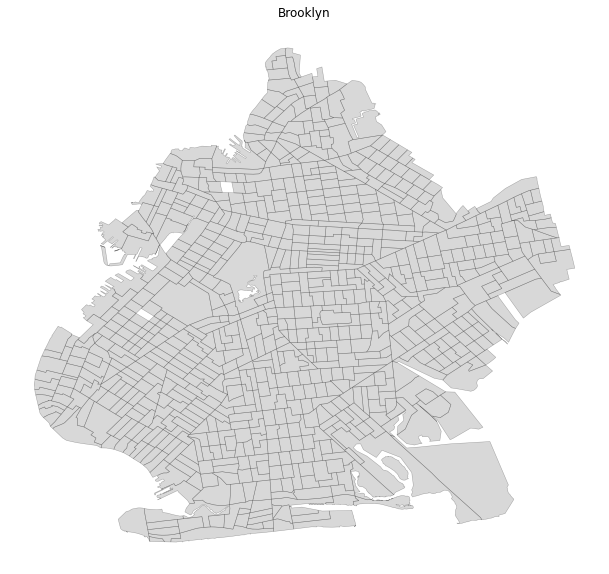

In [8]:
# check plot

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BK_trees_sqmile.plot(ax = ax, alpha = 0.3, edgecolor = 'black', linewidth = 0.5, color = 'gray')

ax.axis('off')
ax.set(title = 'Brooklyn')

plt.savefig("maps/Brooklyn/Brooklyn_CTs.pdf")

In [9]:
# first - drop cells containing Null values (cells containing zero points) - or code will not work
BK_trees_sqmile = BK_trees_sqmile.dropna(subset = ['trees_per_sqmile'])

In [10]:
# drop trees per capita with 0
BK_trees_sqmile = BK_trees_sqmile.query("trees_per_sqmile > 0")

In [11]:
# create queen contiguity weights
w_BK = weights.Queen.from_dataframe(BK_trees_sqmile)

In [13]:
# fill in islands with KNN weights
w_knn_BK = weights.KNN.from_dataframe(BK_trees_sqmile, k=1)

In [14]:
w_BK = weights.attach_islands(w_BK, w_knn_BK)

There are no disconnected observations (no islands)!


In [15]:
# row standardize weights
w_BK.transform = 'R'

## Spatial Autocorrelation - Local Moran's I
### *removed all census tracts with 0 trees per square mile*

In [16]:
# on trees per capita
local_moran_BK = esda.moran.Moran_Local(BK_trees_sqmile['trees_per_sqmile'], w_BK)

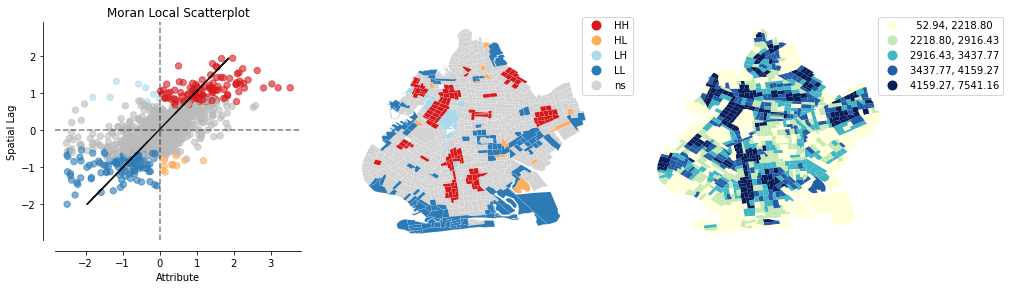

In [17]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_BK, BK_trees_sqmile,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/Brooklyn/Brooklyn_Trees-per-SquareMile_moran.pdf")

In [18]:
# get clusters and outliers - adding columns to the DF

BK_trees_sqmile['local_moran_Is'] = local_moran_BK.Is
BK_trees_sqmile['local_moran_p_value'] = local_moran_BK.p_sim
BK_trees_sqmile['local_moran_quadrant'] = local_moran_BK.q

In [19]:
# get statisically significant clusters and outliers

alpha = 0.05
hotspots_BK = BK_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_BK = BK_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_BK = BK_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_BK = BK_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

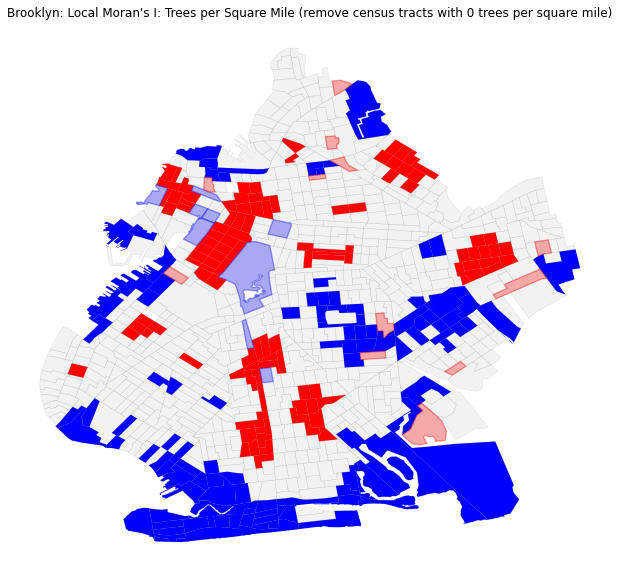

In [20]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BK_trees_sqmile.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
BK_trees_sqmile.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_BK.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_BK.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_BK.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_BK.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Brooklyn: Local Moran's I: Trees per Square Mile (remove census tracts with 0 trees per square mile)")

plt.savefig("maps/Brooklyn/Brooklyn_Trees-per-SquareMile.pdf")

### *investigate the numbers*

In [41]:
# look at smallest values
BK_trees_sqmile['trees_per_sqmile'].nsmallest(n=10)

1397     52.941923
1186     72.168766
679      76.421477
274      86.278071
988      88.806707
1690    102.083172
1009    149.224368
1287    171.229929
1505    182.153024
1392    192.780063
Name: trees_per_sqmile, dtype: float64

In [39]:
# look at largest values
BK_trees_sqmile['trees_per_sqmile'].nlargest(n=10)

1815    7541.158313
1175    7139.380149
1777    6927.917597
1120    6647.135891
1302    6438.000962
1640    6373.679016
23      6298.347046
31      6130.317966
2192    6011.758227
1035    5982.185526
Name: trees_per_sqmile, dtype: float64

In [74]:
# lowest 1% of data
print(BK_trees_sqmile['trees_per_sqmile'].quantile(q = 0.01))

181.16994533515145


In [75]:
# lowest 5% of data
print(BK_trees_sqmile['trees_per_sqmile'].quantile(q = 0.05))

933.6311216104484


In [76]:
# lowest 10% of data
print(BK_trees_sqmile['trees_per_sqmile'].quantile(q = 0.10))

1631.4889262835422


In [77]:
# lowest 20% of data
print(BK_trees_sqmile['trees_per_sqmile'].quantile(q = 0.20))

2218.8014229304713


In [78]:
# highest 1% of data
print(BK_trees_sqmile['trees_per_sqmile'].quantile(q = 0.99))

6022.428603548889


In [79]:
# highest 5% of data
print(BK_trees_sqmile['trees_per_sqmile'].quantile(q = 0.95))

5176.778353670801


In [80]:
# highest 10% of data
print(BK_trees_sqmile['trees_per_sqmile'].quantile(q = 0.90))

4755.508381867019


In [81]:
# highest 20% of data
print(BK_trees_sqmile['trees_per_sqmile'].quantile(q = 0.80))

4159.267501046064


## Spatial Autocorrelation - Local Moran's I - limited
### *removed all census tracts with less than 200 and more than 6,000  trees per square mile*

In [21]:
# limit the range
BK_trees_sqmile_limit = BK_trees_sqmile.query("trees_per_sqmile > 200 & trees_per_sqmile < 6000")

In [22]:
# create queen contiguity weights
w_BK2 = weights.Queen.from_dataframe(BK_trees_sqmile_limit)

In [25]:
# fill in islands with KNN weights
w_knn_BK2 = weights.KNN.from_dataframe(BK_trees_sqmile_limit, k=1)

In [26]:
w_BK2 = weights.attach_islands(w_BK2, w_knn_BK2)

There are no disconnected observations (no islands)!


In [27]:
# row standardize weights
w_BK2.transform = 'R'

In [28]:
# on trees per capita
local_moran_BK2 = esda.moran.Moran_Local(BK_trees_sqmile_limit['trees_per_sqmile'], w_BK2)

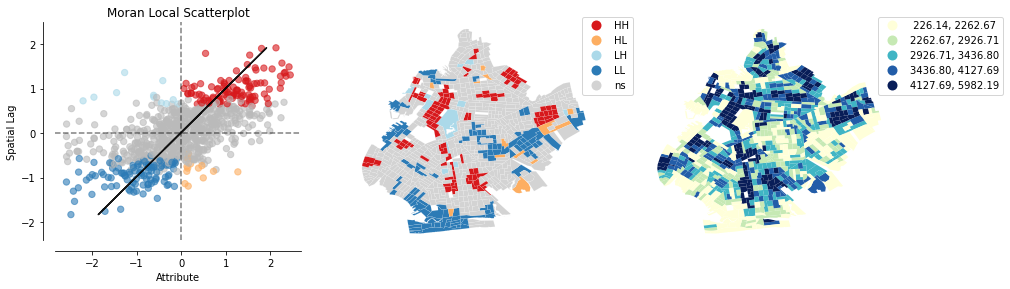

In [29]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_BK2, BK_trees_sqmile_limit,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/Brooklyn/Brooklyn_Trees-per-SquareMile_limited_moran.pdf")

In [35]:
# get clusters and outliers
BK_trees_sqmile_limit['local_moran_Is'] = local_moran_BK2.Is
BK_trees_sqmile_limit['local_moran_p_value'] = local_moran_BK2.p_sim
BK_trees_sqmile_limit['local_moran_quadrant'] = local_moran_BK2.q

In [36]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_BK2 = BK_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_BK2 = BK_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_BK2 = BK_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_BK2 = BK_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

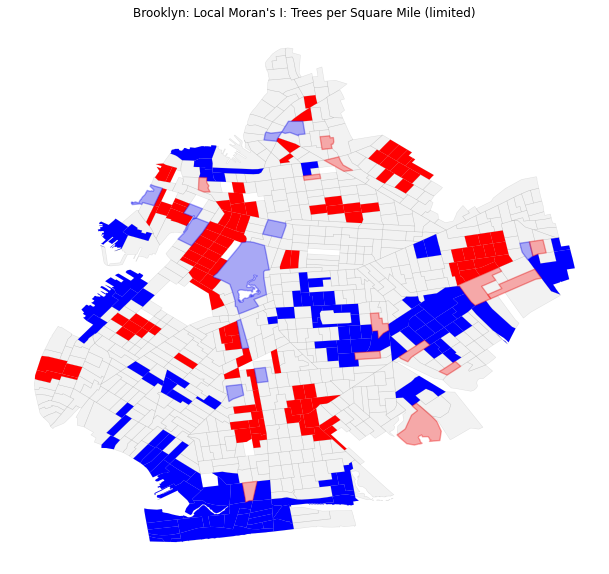

In [37]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BK_trees_sqmile_limit.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
BK_trees_sqmile_limit.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_BK2.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_BK2.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_BK2.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_BK2.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Brooklyn: Local Moran's I: Trees per Square Mile (limited)")

plt.savefig("maps/Brooklyn/Brooklyn_Trees-per-SquareMile_limited.pdf")

## Spatial Autocorrelation - Local Moran's I - more limited
### *removed all census tracts with less than 400 and more than 5,500  trees per square mile*

In [42]:
# limit the range
BK_trees_sqmile_limit_more = BK_trees_sqmile_limit.query("trees_per_sqmile > 400 & trees_per_sqmile < 5500")

In [43]:
# create queen contiguity weights
w_BK3 = weights.Queen.from_dataframe(BK_trees_sqmile_limit_more)

In [45]:
# fill in islands with KNN weights
w_knn_BK3 = weights.KNN.from_dataframe(BK_trees_sqmile_limit_more, k=1)

In [46]:
w_BK3 = weights.attach_islands(w_BK3, w_knn_BK3)

There are no disconnected observations (no islands)!


In [47]:
# row standardize weights
w_BK3.transform = 'R'

In [48]:
# on trees per capita
local_moran_BK3 = esda.moran.Moran_Local(BK_trees_sqmile_limit_more['trees_per_sqmile'], w_BK3)

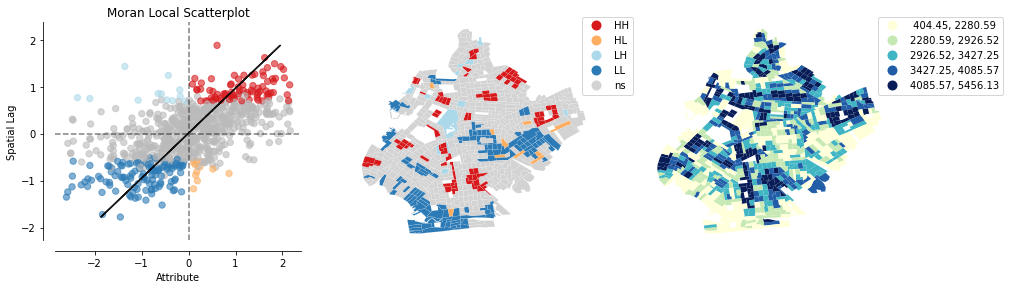

In [49]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_BK3, BK_trees_sqmile_limit_more,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/Brooklyn/Brooklyn_Trees-per-SquareMile_more-limited_moran.pdf")

In [51]:
# get clusters and outliers
BK_trees_sqmile_limit_more['local_moran_Is'] = local_moran_BK3.Is
BK_trees_sqmile_limit_more['local_moran_p_value'] = local_moran_BK3.p_sim
BK_trees_sqmile_limit_more['local_moran_quadrant'] = local_moran_BK3.q

In [52]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_BK3 = BK_trees_sqmile_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_BK3 = BK_trees_sqmile_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_BK3 = BK_trees_sqmile_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_BK3 = BK_trees_sqmile_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

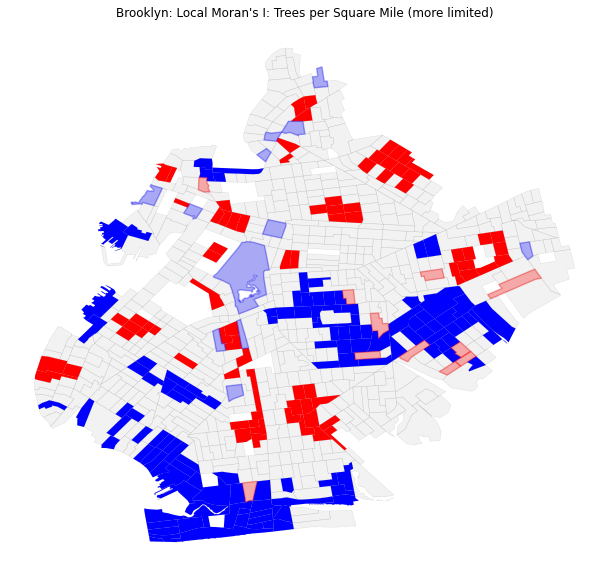

In [54]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
BK_trees_sqmile_limit_more.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
BK_trees_sqmile_limit_more.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_BK3.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_BK3.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_BK3.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_BK3.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Brooklyn: Local Moran's I: Trees per Square Mile (more limited)")

plt.savefig("maps/Brooklyn/Brooklyn_Trees-per-SquareMile_more-limited.pdf")